In [1]:
#도구 준비
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams

## STEP 1. 데이터셋 구성하기

In [2]:
#데이터 불러오기
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

In [3]:
#정규화하기

train_x = (train_x - 127.5) / 127.5

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


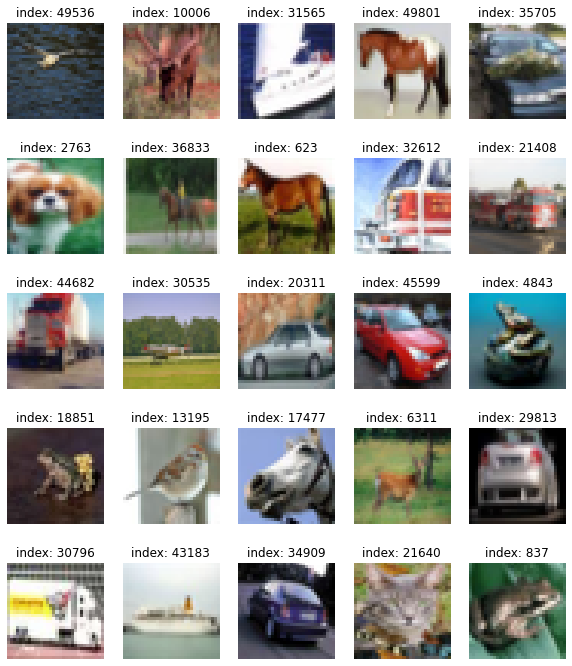

In [4]:
#시각화하기
#plt는 input 데이터의 크기를 [0,1] 또는 [0,255]을 맞춰준다.

plt.figure(figsize=(10, 12))

for i in range(25):
    # [[YOUR CODE]]
    plt.subplot(5, 5, i+1)
    t = np.random.randint(50000)
    sample = (train_x[t] + 1) / 2
    plt.imshow(sample)
    plt.title(f'index: {t}')
    plt.axis('off')

plt.show()

In [5]:
#미니배치 준비

BUFFER_SIZE = 50000
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## STEP 2. 생성자 모델 구현하기

In [6]:
# #gemerator 모델 준비

# def make_generator_model():

#     # Start
#     model = tf.keras.Sequential()

#     # First: Dense layer
#     model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
#     model.add(layers.BatchNormalization())
#     model.add(layers.LeakyReLU())

#     # Second: Reshape layer
#     model.add(layers.Reshape((8, 8, 256)))

#     # Third: Conv2DTranspose layer
#     model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
#     model.add(layers.BatchNormalization())
#     model.add(layers.LeakyReLU())

#     # Fourth: Conv2DTranspose layer
#     model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
#     model.add(layers.BatchNormalization())
#     model.add(layers.LeakyReLU())

#     # Fifth: Conv2DTranspose layer
#     model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
#                                      activation='tanh'))

#     return model

In [7]:
#deeper model

def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())    
    
    # Sixth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(4, 4), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Seventh: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [8]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

### 데이터 크기 변화
(8,8,256) -> (16,16,64) -> (32,32,3)

(1, 32, 32, 3)


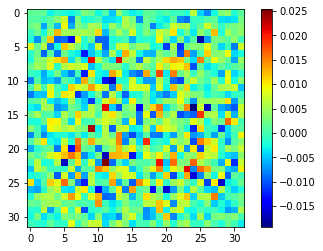

In [9]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
print(generated_image.shape)
plt.imshow(generated_image[0, :, :, 0], cmap = 'jet')
plt.colorbar()
plt.show()

## STEP 3. 판별자 모델 구현하기

In [10]:
# #discriminator 모델 준비

# def make_discriminator_model():

#     # Start
#     model = tf.keras.Sequential()

#     # First: Conv2D Layer
#     model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
#     model.add(layers.LeakyReLU())
#     model.add(layers.Dropout(0.3))

#     # Second: Conv2D Layer
#     model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
#     model.add(layers.LeakyReLU())
#     model.add(layers.Dropout(0.3))

#     # Third: Flatten Layer
#     model.add(layers.Flatten())

#     # Fourth: Dense Layer
#     model.add(layers.Dense(1))

#     return model

In [11]:
#deeper model

def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))    
    
    # Fourth: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))    
    
    # Fifth: Flatten Layer
    model.add(layers.Flatten())

    # Sixth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [12]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 128)        

### 데이터 크기 변화
(32, 32, 3) -> (16, 16, 64) -> (8, 8, 128) -> (1, 1, 8192) -> 1

In [13]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00108127]], dtype=float32)>

-0.00358811

## STEP 4. 손실함수와 최적화함수 구현하기

In [14]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [15]:
#loss function 준비

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [16]:
# accuracy function 준비

def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

In [17]:
#최적화 함수 준비

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

## STEP 5. 훈련과정 상세 기능 구현하기

In [18]:
#변수설정

noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

In [19]:
#train step 함수 준비

@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [20]:
#시각화 함수 준비

def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap = 'jet')
        plt.axis('off')

    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

In [21]:
#그래프 history 함수 준비

rcParams['figure.figsize'] = 15, 6

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

In [22]:
#모델 체크포인트 준비

checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## STEP 6. 학습 과정 진행하기

In [23]:
#학습 과정 구현

def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [24]:
#변수 지정

save_every = 5
EPOCHS = 200

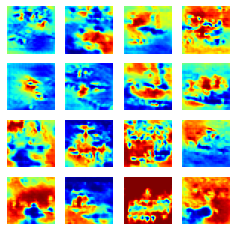

Time for training : 5686 sec


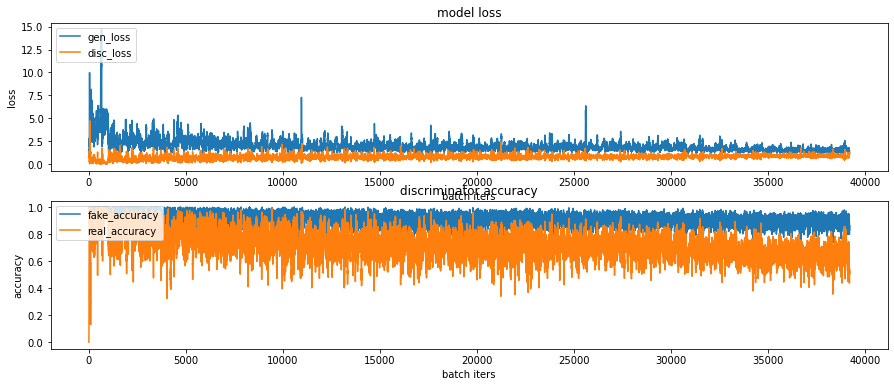

CPU times: user 1h 34min 3s, sys: 1min 20s, total: 1h 35min 24s
Wall time: 1h 34min 47s


In [25]:
%%time
train(train_dataset, EPOCHS, save_every)

file:///home/aiffel0042/aiffel/dcgan_newimage/cifar10/fashion_mnist_dcgan.gif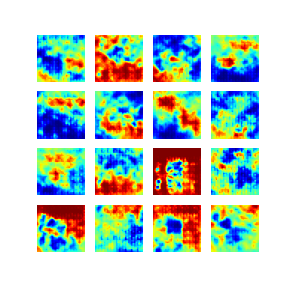
EPOCH 50으로는 의미있는 결과를 만들어내지 못했다.

In [26]:
# checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

# latest = tf.train.latest_checkpoint(checkpoint_dir)
# checkpoint.restore(latest)

# generator = checkpoint.generator
# discriminator = checkpoint.discriminator

# # 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
# noise = tf.random.normal([1, 100])
# generated_image = generator(noise, training=False)

# np_generated = generated_image.numpy()
# np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
# np_generated = np_generated.astype(int)
# plt.imshow(np_generated[0])
# plt.show()

In [27]:
# %%time
# train(train_dataset, EPOCHS, save_every)

fake accuracy가 감소하지 않는 문제가 발생했다.

In [28]:
#샘플 시각화

anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/fashion_mnist_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif

-rw-r--r-- 1 aiffel0042 aiffel0042 1280430 10월  5 16:54 /home/aiffel0042/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif


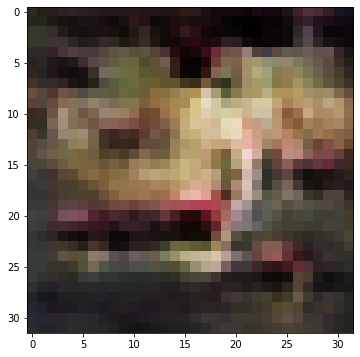

In [29]:
# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()

STEP 7. (optional) GAN 훈련 과정 개선하기

# 총평

### 데이터 분석

file:///home/aiffel0042/aiffel/dcgan_newimage/cifar10/temp/normal_history.png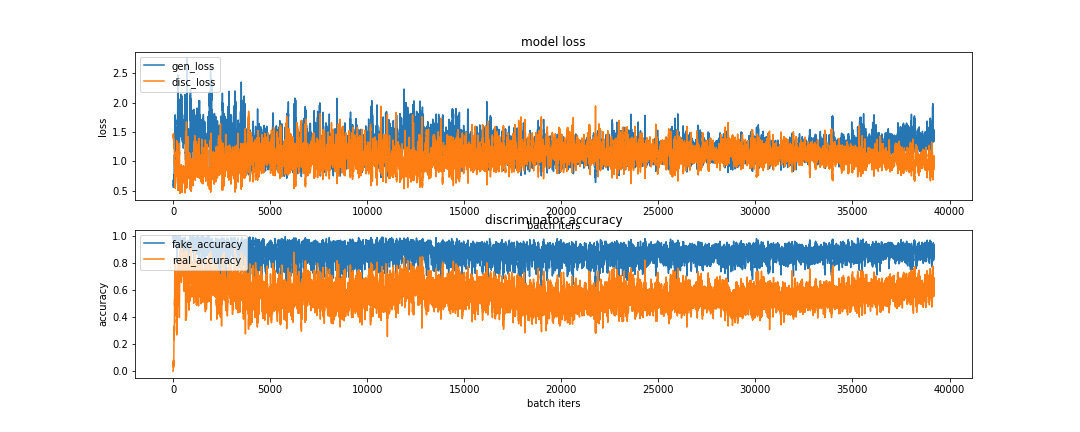

기존 모델에선 뚜렷한 개선 지표가 보이지 않는다.

file:///home/aiffel0042/aiffel/dcgan_newimage/cifar10/temp/train_history_0499.png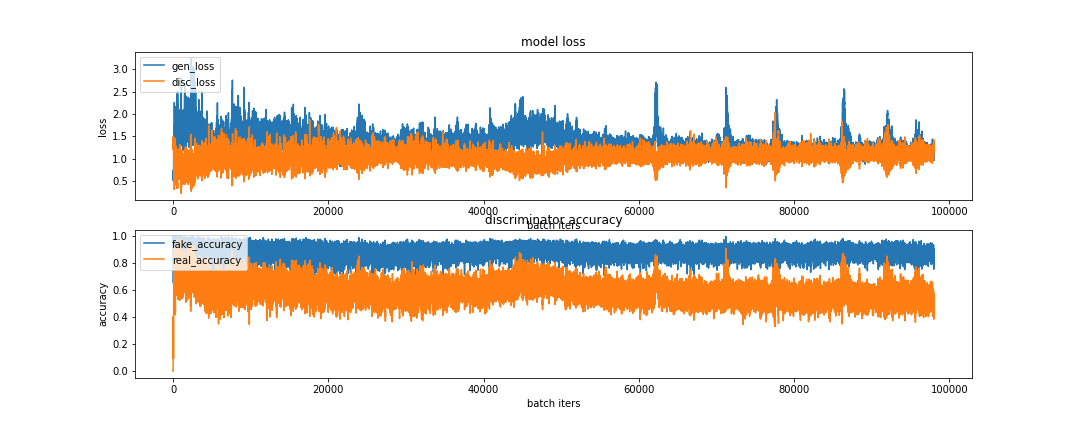

Epoch를 500까지 확장했을때 약간의 개선이 있지만 fake accuracy의 경우 변화가 미미할뿐더러 accuracy와 loss에서 심한 노이즈가 발견된다.

### 개선사항

이를 개선하기 위해 두가지를 개선했다.
1.local minimum에 빠졌을 가능성을 위해 batch size 변경.
2.모델 layer 추가.

file:///home/aiffel0042/aiffel/dcgan_newimage/cifar10/training_history/train_history_0199.png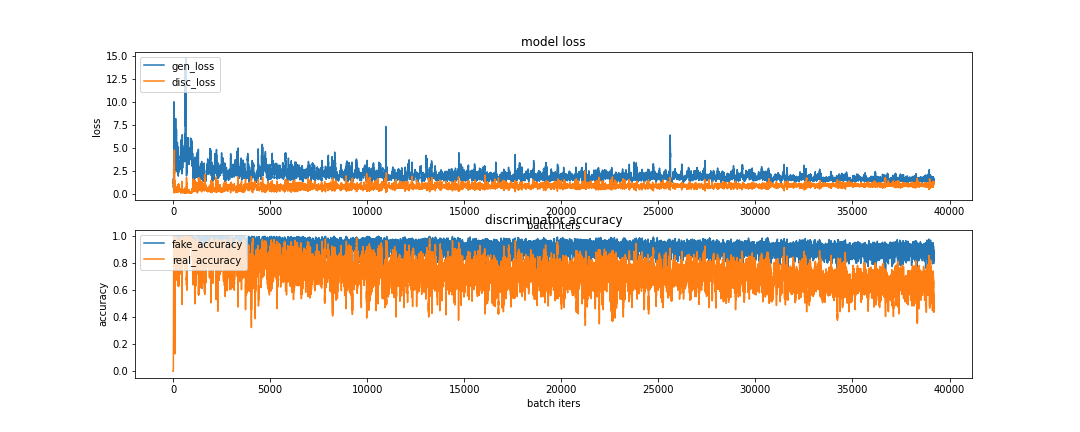

그 결과 fake accuracy는 0.9, real accuracy는 0.7까지 감소했다. 특히 fake accuracy의 노이즈가 상당히 줄어들었으며 loss 역시 안정적으로 수렴하는 것을 확인할 수 있었다.

### 추가적으로 필요한 작업

개선 전 샘플
file:///home/aiffel0042/aiffel/dcgan_newimage/cifar10/temp/normal.gif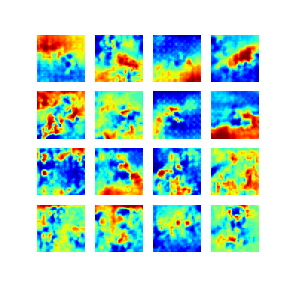

개선 후 샘플
file:///home/aiffel0042/aiffel/dcgan_newimage/cifar10/fashion_mnist_dcgan.gif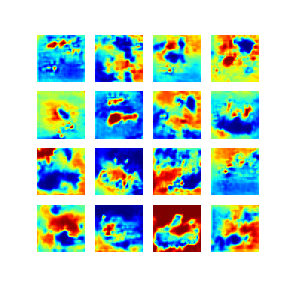

무슨 물체가 있는 듯한 느낌만 줄 뿐 명확하게 사물의 형태가 출력되진 않았다. 따라서 다음 세가지 작업이 추가되어야 할 것으로 보인다.
1.fake accuracy learning rate 개선
2.epoch 추가
3.real accuracy 노이즈 개선